# Density estimation 

# K means clustering

KMeans is trying to solve the following optimization problem:

\begin{align}
\arg \min_S \sum_{i=1}^K \sum_{x_j \in S_i} ||x_j - \mu_i||^2
\end{align}
where one needs to partition the N observations into K clusters: $S = \{S_1, S_2, \ldots, S_K\}$ and each cluster has $\mu_i$ as its center.

In [ ]:
class KMeans(object):
    
    def __init__(self): 
        pass
    
    def pairwise_dist(self, x, y):
        np.random.seed(1)
        """
        Args:
            x: N x D numpy array
            y: M x D numpy array
        Return:
                dist: N x M array, where dist2[i, j] is the euclidean distance between 
                x[i, :] and y[j, :]
        """

        return np.linalg.norm(x[:, None, :] - y[None, :, :], axis=-1)

    def _init_centers(self, points, K, **kwargs):
        np.random.seed(1)
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            kwargs: any additional arguments you want
        Return:
            centers: K x D numpy array, the centers. 
        """

        return points[np.random.choice(points.shape[0], size=K, replace=False)]

    def _update_assignment(self, centers, points):
        np.random.seed(1)
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            points: NxD numpy array, the observations
        Return:
            cluster_idx: numpy array of length N, the cluster assignment for each point
        """

        distanceMatrix = self.pairwise_dist(centers, points)
        return np.argmin(distanceMatrix, axis=0)
   
    
    def _update_centers(self, old_centers, cluster_idx, points):
        np.random.seed(1)
        """
        Args:
            old_centers: old centers KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            centers: new centers, K x D numpy array, where K is the number of clusters, and D is the dimension.
        """

        #Need to querey all points that share the same cluster_idx
        #Start by getting indecies of all points with cluster k
        #access array with indecies

        K = old_centers.shape[0]
        for i in range(K):
          cluster_point_indecies = np.where(cluster_idx == i) #get indecies of points in cluster i
          cluster_points = points[cluster_point_indecies] #get points in cluster i
          old_centers[i] = np.mean(cluster_points, axis=0) #assign the mean point to the old cluster

        return old_centers

    def _get_loss(self, centers, cluster_idx, points):
        np.random.seed(1)
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            loss: a single float number, which is the objective function of KMeans. 
        """

        #step 1: l2 norm of the cluster points subtracted from their centroids
        #step 2: sum over the points
        #step 3: repeat fore each cluster

        K = centers.shape[0]
        sum = 0.0
        for i in range(K):
          cluster_point_indecies = np.where(cluster_idx == i) #get indecies of points in cluster i
          cluster_point = points[cluster_point_indecies] #get points in cluster i
          inner_operation = (np.linalg.norm(cluster_point - centers[i], axis=1, ord=2))**2 #apply l2 norm
          sum += np.sum(inner_operation)
        return sum
        
    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, verbose=False, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations (Hint: You could change it when debugging)
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            verbose: boolean to set whether method should print loss (Hint: helpful for debugging)
            kwargs: any additional arguments you want
        Return:
            cluster assignments: Nx1 int numpy array
            cluster centers: K x D numpy array, the centers
            loss: final loss value of the objective function of KMeans
        """

        centers = self._init_centers(points, K, **kwargs)
        for it in range(max_iters):
            cluster_idx = self._update_assignment(centers, points)
            centers = self._update_centers(centers, cluster_idx, points)
            loss = self._get_loss(centers, cluster_idx, points)
            K = centers.shape[0]
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            if verbose:
                print('iter %d, loss: %.4f' % (it, loss))
        return cluster_idx, centers, loss
    
    def find_optimal_num_clusters(self, data, max_K=15,iteration = 100):
        np.random.seed(1)
        """
        Plots loss values for different number of clusters in K-Means
        
        Args:
            data: input data of shape(samples, 2)
            max_K: number of clusters
        Return:
            losses: a list, which includes the loss values for different number of clusters in K-Means
            Plot loss values against number of clusters
        """

        plot_data = []
        for i in range(max_K):
          results = self.__call__(data, i + 1)
          plot_data.append(results[2]) 

        plt.scatter(np.arange(1, 16), plot_data)
        return plot_data

# Gaussian mixture model

A Gaussian Mixure Model (GMM) is a probabilistic model that assumes all the data points are generated from a mixure of a finite number of Gaussian Distributions. In a nutshell, GMM is a soft clustering algorithm in a sense that each data point is assigned to a cluster with a probability. In order to do that, we need to convert our clustering problem into an inference problem.

Given $N$ samples $\mathbf{X} = [\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N]^T$, where $\mathbf{x}_i \in \mathbb{R}^D$. Let $\mathbf{\pi}$ be a $K$-dimensional probability distribution and $(\mathbf{\mu}_k; \mathbf{\Sigma}_k)$ be the mean and covariance matrix of the $k^{th}$ Gaussian distribution in $\mathbb{R}^D$. 

The GMM object implements an EM algorithm for fitting the model and MLE for optimizing its parameters. It also has certain hypothesis on how the data was generated:

- Each data point $\mathbf{x}_i$ is assigned to a cluster $k$ with probability of $\pi_k$ where $\sum_{k=1}^K \pi_k = 1$
- Each data point $\mathbf{x}_i$ is generated from a multivariate normal distribution $\cal{N}(\mu_k, \Sigma_k)$ where $\mu_k \in \mathbb{R}^D$ and $\Sigma_k \in \mathbb{R}^{D\times D}$

Our Goal is to find $K$-dimension gaussian distributions to model our data $\mathbf{X}$. This can be done by learning the parameters $\mathbf{\pi}, \mathbf{\mu}$ and $\mathbf{\Sigma}$. The detailed derivation can be found in our slide of GMM. The log-likelihood function now becomes:

\begin{align}
    \text{ln } p(\mathbf{x}_1, \dots, \mathbf{x}_N | \mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}) = \sum_{i=1}^N \text{ln } \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(\mathbf{x}_i | \mathbf{\mu}_k, \mathbf{\Sigma}_k)\big)
\end{align}

- **E-step:** Evaluate the responsibilities

In this step, we need to calculate the responsibility $\gamma$, which is the conditional probability that a datapoint belongs to a specific cluster $k$ if we are given the datapoint, i.e. $P(z_k|x)$. The formula for $\tau$ is given below:

$$
\gamma\left(z_k\right)=\frac{\pi_{k} N\left(\mathbf{x} | \mathbf{\mu}_{k}, \mathbf{\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} N\left(\mathbf{x} | \mathbf{\mu}_{j}, \mathbf{\Sigma}_{j}\right)}, \quad \text{for } k = 1, \dots, K
$$
Note that each data point should have one probability for each component/cluster. For this homework, you will work with $\gamma\left(z_k\right)$ which has a size of $N\times K$ and you should have all the responsibility values in one matrix.

- **M-step:** Re-estimate parameters

After we obtained the responsibility, we can find the update of parameters, which are given below:

\begin{align}
\mathbf{\mu}_k^{new} &= \dfrac{\sum_{n=1}^N \gamma(z_k)\mathbf{x}_n}{N_k} \\
\mathbf{\Sigma}_k^{new} &= \dfrac{1}{N_k}\sum_{n=1}^N \gamma (z_k)^T(\mathbf{x}_n - \mu_k^{new})^T(\mathbf{x}_n-\mu_k^{new}) \\
\pi_k^{new} &= \dfrac{N_k}{N}
\end{align}
where $N_k = \sum_{n=1}^N \gamma(z_k)$. Note that the updated value for $\mu_k$ is used when updating $\mathbf{\Sigma}_k$. The multiplication of $\gamma (z_k)^T(\mathbf{x}_n - \mu_k^{new})^T$ is element-wise so it will preserve the dimensions of $(\mathbf{x}_n - \mu_k^{new})^T$.

- We repeat E and M steps until the incremental improvement to the likelihood function is small.

In [ ]:
SIGMA_CONST = 1e-6
LOG_CONST = 1e-32
import math

class GMM(object):
    def __init__(self, X, K, max_iters = 100):
        """
        Args: 
            X: the observations/datapoints, N x D numpy array
            K: number of clusters/components
            max_iters: maximum number of iterations (used in EM implementation)
        """

        self.points = X
        self.max_iters = max_iters
        
        self.N = self.points.shape[0]        #number of observations
        self.D = self.points.shape[1]        #number of features
        self.K = K                           #number of components/clusters

    
    def softmax(self, logit):
        """
        Args:
            logit: N x D numpy array
        Return:
            prob: N x D numpy array. See the above function.
        """

        logit -= (np.amax(logit, axis=1))[:, None] #numerically stable
        X = np.exp(logit)
        return X / (np.sum(X, axis=1))[:, None]



    def logsumexp(self, logit):
        """
        Args:
            logit: N x D numpy array
        Return:
            s: N x 1 array where s[i,0] = logsumexp(logit[i,:]). See the above function
        """

        #numerically stable
        logit -= (np.amax(logit, axis=1))[:, None]
        return np.log(np.sum(np.exp(logit), axis=1)[:, None])


    def multinormalPDF(self, logits, mu_i, sigma_i):
        """
        Args: 
            logits: N x D numpy array
            mu_i: 1xD numpy array, the center for the ith gaussian.
            sigma_i: 1xDxD numpy array, the covariance matrix of the ith gaussian.  
        Return:
            normal_pdf: 1xN numpy array, the probability distribution of N data for the ith gaussian
        """

        lowerExp = logits.shape[1] / 2
        det = np.linalg.det(sigma_i)

        #computer normalization constant
        doublePi = 2 * np.pi
        bottomLeft = doublePi**lowerExp
        bottomRight = det**1/2
        const = bottomLeft * bottomRight
        normal_const = 1 / const

        #compute the probabilities
        inverse_sigma = np.linalg.inv(sigma_i)
        X_mu = logits - mu_i
        leftSide = np.dot(X_mu, inverse_sigma)
        inner_exp = np.transpose(leftSide) * np.transpose(X_mu)
        inner_exp *= -1/2
        sum_exp = np.sum(inner_exp, axis=0)
        rightSide = np.exp(sum_exp)
        final = normal_const * rightSide

        return final
    
    def _init_components(self, **kwargs):
        """
        Args:
            kwargs: any other arguments you want
        Return:
            pi: numpy array of length K, prior
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxDxD numpy array, the diagonal standard deviation of each gaussian. 
                You will have KxDxD numpy array for full covariance matrix case
        """

        pi = np.full(self.K, 1/self.K) 
        mu = self.points[np.random.choice(self.points.shape[0], size=self.K, replace=False)]
        sigma = np.zeros(shape=(self.K, self.D, self.D))
        for k in range(self.K):
          np.fill_diagonal(sigma[k], np.random.rand(1)) 

        return (pi, mu, sigma)

    
    def _ll_joint(self, pi, mu, sigma, **kwargs):
        """
        Args:
            pi: np array of length K, the prior of each component
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxDxD numpy array, the diagonal standard deviation of each gaussian. You will have KxDxD numpy
            array for full covariance matrix case
            
        Return:
            ll(log-likelihood): NxK array, where ll(i, k) = log pi(k) + log NormalPDF(points_i | mu[k], sigma[k])
        """

        ll = np.zeros(shape=(self.N, self.K))
        for k in range(self.K): 
          lpdf = np.log(pi[k]) + np.log(self.multinormalPDF(self.points, mu[k], sigma[k]))
          ll[:, k] = lpdf 
        return ll


    def _E_step(self, pi, mu, sigma, **kwargs):
        """
        Args:
            pi: np array of length K, the prior of each component
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxDxD numpy array, the diagonal standard deviation of each gaussian.You will have KxDxD numpy
            array for full covariance matrix case
        Return:
            gamma(tau): NxK array, the posterior distribution (a.k.a, the soft cluster assignment) for each observation.
        """

        X = self._ll_joint(pi, mu, sigma)
        return self.softmax(X)


    def _M_step(self, gamma, **kwargs): 
        """
        Args:
            gamma(tau): NxK array, the posterior distribution (a.k.a, the soft cluster assignment) for each observation.
        Return:
            pi: np array of length K, the prior of each component
            mu: KxD numpy array, the center for each gaussian. 
            sigma: KxDxD numpy array, the diagonal standard deviation of each gaussian. You will have KxDxD numpy
            array for full covariance matrix case
        """

        class_gamma = np.sum(gamma, axis=0)
        u_pi = np.zeros(shape=(self.K))
        u_mu = np.zeros(shape=(self.K, self.D))
        u_sigma = np.zeros(shape=(self.K, self.D, self.D))
        for k in range(self.K):
          u_pi[k] = class_gamma[k] / self.N
          u_mu[k] = np.sum((gamma[:, k, None] * self.points), axis=0) / class_gamma[k] 
          X_mu = self.points - u_mu[k]
          u_sigma[k] = (1 / class_gamma[k]) * (np.dot(np.transpose(gamma)[k] * np.transpose(X_mu), X_mu))
        

        return (u_pi, u_mu, u_sigma)
    
    
    def __call__(self, abs_tol=1e-16, rel_tol=1e-16, **kwargs):
        """
        Args:
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            kwargs: any additional arguments you want
        
        Return:
            gamma(tau): NxK array, the posterior distribution (a.k.a, the soft cluster assignment) for each observation.
            (pi, mu, sigma): (1xK np array, KxD numpy array, KxDxD numpy array)       
        """

        pi, mu, sigma = self._init_components(**kwargs)
        pbar = tqdm(range(self.max_iters))
        
        for it in pbar:
            # E-step
            gamma = self._E_step(pi, mu, sigma)
            
            # M-step
            pi, mu, sigma = self._M_step(gamma)
            
            # calculate the negative log-likelihood of observation
            joint_ll = self._ll_joint(pi, mu, sigma)
            loss = -np.sum(self.logsumexp(joint_ll))
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            pbar.set_description('iter %d, loss: %.4f' % (it, loss))
        return gamma, (pi, mu, sigma)

# Dimensionality reduction


## PCA

Assume a dataset is composed of N datapoints, each of which has D features with D < N.  The *dimension* of our data would be $D$. It is possible, however, that many of these dimensions contain redundant information.  The *intrinsic dimensionality* is the number of dimensions we need to reconstruct our data with high fidelity.  For our purposes, we will define the intrinsic dimension as the number of principal components needed to reconstruct 99% of the variation within our data.

We define a set of features as linearly independent if we cannot construct one out of a linear combination of the others. The number of linearly independent features is the number of nonzero principal components (where we define 0 is anything less than $10^{-11}$ due to floating point error). Zero principal components mean that we can not find any weights to linearly combine features in order to create an indenpendent feature. Thus, our algorithm will assign 0 to these weights.


In [ ]:
import numpy as np

class Dimensionality(object):
    def __init__(self):
        pass

    def pca(self, X):
        """
        Decompose dataset into principal components using singular value decomposition. 

        Step 1: Calculate the mean (mu) and covariance matrix (C) from data
        Step 2: Find eigenvectors (W) and values (lambda) of C in descending order
        Step 3: Compute reduced feature space -> W[(X - mu) / sqrt(lambda)] for every point X(n)

        Idea: Maximize the variance along a new dimension with the constrain that it is the unit vector
        - use lagrangian optimization
        - Take the derivative and set it to zero to find optima
        - we find that the new dimensions that maximize the function are the ones that are the eigenvectors of the covariance matrix

        Args: 
            X: N x D array corresponding to a dataset, in which N is the number of points and D is the number of features
        Return:
            U: N x N 
            S: min(N, D) elements
            V: D x D
        """
        return np.linalg.svd(X)

    def recovered_variance_proportion(self, S, k):
        """ 
        Compute the proportion of the variance in the original matrix recovered by a rank-k approximation

        Args:
            S: min(N, D) elements, 1-D array
            k: scalar int, rank of approximation
        Return:
            recovered_var: float corresponding to proportion of recovered variance
        """

        singular_values = S[:k]
        return np.sum(singular_values**2) / np.sum(S**2)



    def intrinsic_dimension(self, S, recovered_variance=.99):
        """
        Find the number of principal components necessary to recover given proportion of variance

        Args: 
            S: 1-d array corresponding to the singular values of a dataset

            recovered_varaiance: float in [0,1].  Minimum amount of variance 
                to recover from given principal components
        Return:
            dim: int, the number of principal components necessary to recover 
                the given proportion of the variance
        """
        for i in range(S.shape[0]):
          rec_var = self.recovered_variance_proportion(S, i)
          if (rec_var >= recovered_variance):
            return i


    def num_linearly_ind_features(self, S, eps=1e-11):
        """
        Find the number of linearly independent features in dataset

        Args: 
            S: 1-d array corresponding to the singular values of a dataset
        Return:
            dim: int, the number of linearly independent dimensions in our data
        """
        count = 0
        for i in range(S.shape[0]):
          if S[i]**2 > eps:
            count += 1

        return count


    def apply_PCA(self, X):
        """
        Apply the functions you just implemented
        Args: 
            X: N x D array corresponding to a dataset, in which N is the number of points and D is the number of features
            retained variance: floating number
        Return:
            (X_new, num_linearly_ind_features, intrinsic_dimension): The X projection on the new feature space, the number of linearly independent dimensions in our data, the intrinsic dimension
        """
        U, S, V = self.pca(X)
        numLIF = self.num_linearly_ind_features(S)
        ID = self.intrinsic_dimension(S)
        return (np.matmul(X, np.transpose(V)), numLIF, ID)

#linear regression:

Linear regression is the first supervised learning algorithm we'll look at. When it comes to supervision learning, we have two broad categories, classification, and regression.

--------------------------------------------------------------------------

**Remember, the purpose of the machine learning workflow is to find**:

$f(X) ≈ Y$

*when given some input X in* $ℝ^{NxD}$ *and some labeled output Y in* $ℝ^N$

--------------------------------------------------------------------------

Classification occurs when the values of our output $Y$ are discrete and regression occurs when the values are continuous. These are useful because large datasets tend to have a very high amount of variance making it virtually impossible for any search based or brute force solution viable, for example hand written numbers. Having an algorithm to accompodate for the variance in handwriting was one of the first applications of ML, the model being used for sorting mail.

\\
### key point
Supervised learning models undergo two phases when being produced: 
- training: part of the dataset should be used so that the algorithm can begin to fit its model to the data and learn the parameters.
- testing: the rest of the dataset should be used so that the algorithm can test whether or not this fit is accurate.

\\
### Using a basis for regression

Assume $Y$ is a linear function of $X$

$y(X, W) = w_0 +  ... + w_Dx_D$

where $X$ is the input vector and $W$ is a weight vector containing a bias term $w_0$

\\

We can extend this notation using a basis function $Φ_m(X)$ since a linear relationship may not always be the case and we would like to be able to control the degree of the polynomial we want to fit:

$y(X, W) = w_0 + ∑^{M-1}_{m=0}w_mΦ_m(x)$

The basis function phi, takes a vector in $ℝ^D$ and gives a vector in $ℝ^M$. This allows us to capture nonlinearities within in our linear regression, as the weights that we are learning in the new dimensional space are still linear.

\\

We can further simplify this expression if we assign $Φ_0(x) = 1$. The expression becomes: $W^TΦ(X)$ 

Where $W$ is the weight vector and phi is the design matrix: the input X with the applied basis function. This reformating is true since the bias term $w_0$ will remain unweighted in the inner product.

All this sounds well, but we have one problem ... we don't know what the weights are suppose to be!

\\
## learning weights for linear regression

We assume that the target variable of our output $Y$, we can call it $t$ for target, is given by the sum of the deterministic function $y(X, W)$ and some random noise $ϵ$ for good measure:

$t = y(X, W) + ϵ$

Our objective now is to find the weight vector $W$ that will minimize the difference between the real values and predicted values on the model (but also making sure that its not zero, we'll talk about that later)

\\

Given N datapoints, we can find $W$ that will minimize the sum-of-squares using the least squares method. Our objective function is thus:

$L(W) = \frac{1}{2}∑_{n=1}^N(t_n - W^TΦ(x_n))^2$

This formula simply takes the sum of the squared differences between the target values and the predicted values. To find the optimal W, as with most optimization solutions, we take the derivative w/ respect to $W$ and set it equal to zero and solve.

$\frac{ΔL(W)}{ΔW} = ∑^N_{n=1}(t_n - W^TΦ(x_n))Φ(x_n)^T$

Setting the result equal to zero and expanding some terms we get the following:

$w = (Φ^TΦ)^{-1}Φ^Tt$

Where phi is the design matrix as mentioned earlier (applying the basis function to every point to the input $X$)

This changes the dimensions of your dataset from $N x D$ to $N x M$ where $M$ is the degree of your basis function.

\\
We have a closed form solution to our optimization which is good! But we still have a big problem, and that is we are doing an inversion operation in it. This is a problem because invertable matricies must be singular (linearly independent) which is a very strict requirement considering real world data is very messy. It also should be mentioned that inverting a matrix has a horrible time complexity $O(n^3)$, and should be avoided in most cases.

We have an open solution however that is much better however:

\\
## Gradient descent

Going back to our objective function (adding 1/N instead of 1/2 for normilization), we know that the negative of the gradient of our function

$\frac{ΔL(W)}{ΔW} = \frac{1}{N}∑^N_{n=1}(t_n - W^TΦ(x_n))Φ(x_n)^T$

will always point in the direction of greatest descent. This means we can iterativly follow the derivative of our objective function to find local minima. The problem is that its a local minima, not a global minima, so getting stuck with subpar weights is possible without certain methods to overcome this.

\\
### Batch gradient descent
- We sum the gradients over the entire dataset and do it all in one go. We add in a hyperparameter alpha, called the learning rate. This tells us how much we should follow the gradient per iteration. Steps too large may cause us to overshoot and oscillate over the local optima, steps that are too small will take too long to converge.

$W_{τ+1} = W_τ - α\frac{ΔL(W)}{ΔW}$

pros: fast-converging, easy to implement
cons: need to read all our data...

\\
### Stochastic gradient descent
- randomly picks a point and follows the gradient till it hits zero. The learning rate is called beta in this case.

$W_{τ+1} = W_τ - β\frac{ΔL(W)}{ΔW}$

However in this case it is without the sum, only one data point is considered at a time:

$\frac{ΔL(W)}{ΔW} = (t_n - W^TΦ(x_n))Φ(x_n)^T$

\\
### The problem of overfitting

We know we can fit varying degrees of polynomial functions to our data, but overfitting can be a very big problem. If our data captures too much of the variance in our data, accounting for outliers and everything, its likely that our model will not make very good predictions for data outside its training dataset as it weights its training data far too heavily.

**We then know that the problem of overfitting stems from the fact that each feature is being weighed too much in our training dataset, or in other words we are capturing the variance of one particular dataset too much, and losing its generalizability.**
- Naturally, we want a solution that tells our regression to stop fitting over the data when the weights achieve a certain value.

\\
## Regularization

Another way to word this solution, is that we want optomize our regression to give the minimum error, given that we stay within a certain range of values. For anyone who has taken a multi class, we understand that this means we must perform constrained optomization!

Let $E_D(W)$ be our sum of squares error we covered earlier, a function that takes in our weights and finds the error with respect to the data. Taking a page from lagrangian multipliers, we know if we want to optomize this function with a constraint, we must add the constriant function times some factor of lambda. To formalize our constraint we should say that the magnitude of the weight vector shouldnt exceed a certain length, formally this would be through using a norm. 

Thus (The l2 norm squared is the same as taking the inner product):

$W^TW ≤ C$

Where C is some threshold


We know from lagrangian multipliers, that the gradient where the function and constraint are tangential are proportional, meaning one is simply a multiple of the other and visversa, we can call this $λ$

Finding the derivative of both the constraint and error function we get the following expression:

\\
Thus we get:

$E_T(W) = E_D(W) + λE_W(W)$

where

$E_W(W) = ∑^M_{m=1}|w_m|^q$

where q is a hyperparameter that we must choose for the type of optomization. Note that if q is equal to two, than it can be written as $W^TW$

## Ridge regression

Put all together for the case of q = 2 (called ridge regression), we get the following expression:

$E_T(W) = \frac{1}{2}(t - ΦW)^T(t-ΦW) + \frac{λ}{2}W^TW$

minimizing this functions derivative will give us the new values of the weights that account for overfitting. Whats more is that doing so results in a closed form solution! 

$\frac{δE(W)}{δW} = (Φ^TΦ + λI)^{-1}Φ^Tt $

Where lambda is our choice for how strict we want to regularize our data, $I$ is the identity matrix

Now you've probably already seen it, but we have another inverse operation!

## Lasso regression

Another technique for regularization is to have our regulation term be q = 1, instead of 2. This gives us the sum expression you saw earlier: 

$∑^{M-1}_{m=0}|w_m| ≤ C$

\\

### Choosing lambda

We have introduced some new hyperparameters lambda and q, but how do we know what choice is best? For things like q, its not so hard since the choices are limited due to its discrete nature 1, 2 ... etc., but lambda is completely arbitrary and continious.

In order to choose we must do some testing, one way is to do leave-one-out cross-validation. For increasing values of lambda, train your model on a portion of the training data, except the nth data point. Rinse and repeat switching the nth data point to the next till you've done it N times. The series of test errors on the N left out points, called the validation set, is averaged and graphed. Doing this process for varying lambda will give you an empircal way to choose the best lambda, the best value being the minimum validation error.










\\

\\
# Naive bayes classifier:

$p(t=i|X) = \frac{p(X|t = i)p(t = i)}{p(X)}$

Given the likelihood of our data, the prior and evidence we can calculate the posterior using bayes rule.

What makes it naive is that we asusme that the label and features are conditionally independent. Problem is the naive assumption may be bad, and we dont explicitly calculate any boundary



\\

\\
# Logistic regression:

Define some terms:

$S = W^TΦ(X)$


$g(s) = \frac{e^s}{1 + e^s}$

$h(x) = p(t|X) = g(s)$

\\
model:

$p(t|X) = g(s)^{t_n}(1-g(s))^{1-t_n}$


\\
Take MLE of $p(t|X)$

$ll(W) = log ∏^N_{n=1}(p(t|X))$

When we take derivative with respect to weights however, we dont get a closed form solution.

The solution is to use the gradient, and since the negative of the log likeli hood function is concave, we know there is one global optima. We take the negative of the gradient to go down for a convex function and the gradient itself if its concave.

Gradient:

$\frac{Δll(W)}{ΔW} = ∑^N_{n=1}(Φ(X_n)(t_n- 1) + (1 - g(s))Φ(X_n)$

GD algo:

$W_{τ+1} = W_τ - α\frac{Δll(W)}{ΔW}$

$While ||W_{τ+1} - W_τ|| > ϵ$

Where epsilon is the threshold to stop






# Linear Regression practice

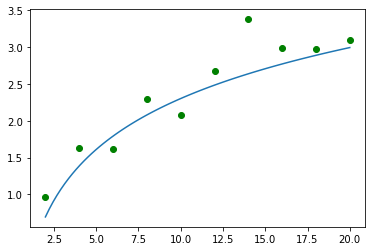

In [ ]:
#import some libraries to create a feature space
import numpy as np
import matplotlib.pyplot as plt

#create some arbitrary dataset with 2 features
data = np.linspace(2.0, 20.0, 10)
#create some noisy targets from your dataset
targets = np.log(data) + np.random.normal(0, .3, 10)

#visualize data
plt.scatter(data, targets, color='green')

#draw out trendline
plt.plot(np.linspace(2, 20, 80), np.log(np.linspace(2, 20, 80)))

#### First start by coding the objective function, which is the sum of the squares formula

In [ ]:
#define the objective function that we want to optimize
def objective_func(weights, targets, design_M):
  return 1/2 * np.sum((targets - np.dot(weights, design_M))**2)

#create a design matrix using simple basis function
def create_DM(data, degree):
  """
    take data, an NxD matrix and give a Nx(Degree) design matrix
  """
  data = np.transpose(np.vstack([data**i for i in range(degree)]))
  return data

# M = 2
design_matrix = create_DM(data, 2)

# Get data dependent error
objective_func()



[[ 1.  2.]
 [ 1.  4.]
 [ 1.  6.]
 [ 1.  8.]
 [ 1. 10.]
 [ 1. 12.]
 [ 1. 14.]
 [ 1. 16.]
 [ 1. 18.]
 [ 1. 20.]]


# Naive bayes: email spam not spam classifier


In [ ]:
import numpy as np
import json
from sklearn.feature_extraction import text

class Naive_Bayes(object):

    def __init__(self): 
        # load emails
        x = open('./emails.txt').read()
        emails = json.loads(x)
        
        # get previous spam emails (spam), non spam emails (not_spam), unclassified input mails (to_classify)
        spam = emails["spam"]
        not_spam = emails["not_spam"]
        to_classify = emails["to_classify"]
        
        # Number of emails
        n_spam = len(spam)
        n_not_spam = len(not_spam)
        n_to_classify = len(to_classify)
        
        ''' To ignore certain common words in English that might skew your model, we add them to the stop words 
         list below. You may want to experiment by choosing your own list of stop words, 
         but be sure to keep subject in this list at a minimum, as it appears in every email content.'''
        stop_words = text.ENGLISH_STOP_WORDS.union({'subject'})        
        
        # Form bag of words model using words used at least 10 times
        vectorizer = text.CountVectorizer(stop_words=stop_words,min_df=10)
        X = vectorizer.fit_transform(spam+not_spam+to_classify).toarray()
        
        # split word counts into separate matrices
        self.X_spam, self.X_not_spam, self.X_to_classify = X[:n_spam,:], X[n_spam:n_spam+n_not_spam,:], X[n_spam+n_not_spam:,:]


    def _likelihood_ratio(self, X_spam, X_not_spam):
        '''
        Args:
            X_spam: n_spam x d where n_spam is the number of spam emails,
                and d is the number of unique words that were there in all the emails
            X_not_spam: n_not_spam x d where n_not_spam is the number of good emails,
                and d is the number of unique words that were there in all the emails
        Return:
            ratio: 1 x d vector of the likelihood ratio of different words (spam/not_spam)
        '''
  
        #get the number of times each word appears in spam
        spam_total_appearances = np.sum(X_spam, axis=0)
        spam_total_appearances += 1
        likelihood_of_spam = spam_total_appearances / np.sum(spam_total_appearances)

        #get the number times each word appears in non_spam
        nonSpam_total_appearances = np.sum(X_not_spam, axis=0)
        nonSpam_total_appearances += 1
        likelihood_of_nonSpam = nonSpam_total_appearances / np.sum(nonSpam_total_appearances)

        return likelihood_of_spam / likelihood_of_nonSpam


    def _priors_ratio(self, X_spam, X_not_spam):
        '''
        Args:
            X_spam: n_spam x d where n_spam is the number of spam emails,
                and d is the number of unique words that were there in all the emails
            X_not_spam: n_not_spam x d where n_not_spam is the number of good emails,
                and d is the number of unique words that were there in all the emails
        Return:
            pr: prior ratio of (spam/not_spam)
        '''
        num_Words = X_spam.shape[1]
        X_spam_prior = np.sum(X_spam) / num_Words 
        X_nonSpam_prior = np.sum(X_not_spam) / num_Words

        return X_spam_prior / X_nonSpam_prior

    def classify_spam(self, likelihood_ratio, pratio, X_to_classify):
        '''
        Args:
            likelihood_ratio: 1 x d vector of ratio of likelihoods of different words
            pratio: a scalar
            X_to_classify: bag of words representation of the unknown emails. k x d, where 
                k is the number of emails to classify and d is the number of unique words that were there in all the emails
        Return:
             resolved: 1 x k list, each entry is 'S' to indicate spam or 'NS' to indicate not spam. 
             k is the number of emails to classify
        '''
        resolved = []
        for i in range(X_to_classify.shape[0]):
          email_wordCount = X_to_classify[i]
          guess = np.prod(likelihood_ratio**(email_wordCount)) * pratio
          if guess > 1:
            resolved.append('S')
          else:
            resolved.append('NS') 

        return resolved



# Decision trees

Sometimes finding a boundary of your dataset is not a singular calculation. Multiple types of boundary at varying locations may be needed.

Each boundary drawn on the data is referred to as a split.

Decision trees classify data using if-then logic:
- Each split is called a fork, and they split into two branches based on some value.
- The goal is to maximize the information gain out of each split
- You keep splitting once all your leaf nodes are pure, meaning they have only 1 kind of labeled data

We can use the entropy gain from the split to determine if any of the D features are a good split for iteration i.

$H(X) = - ∑^K_{k=1} p(x = k) log_2p(x=k)$

High entropy → all the classes are likely
Low entropy → a few classes are likely

In this case entropy captures the purity of our nodes, if the objective is maximize the information gain per split, then naturally the numerical goal here is to find the split that gives the lowest entropy, as entropy is a measure of ambiguity of our data.

For consecutive splits the conditional entropy can be used 
- Given that we split on: $H_{before}$
- The average conditional entropy after splitting would be: $H_{after} = prob_LH_L + prob_RH_R$
- Maximize information gain: $IG = H - H_{after}$

For discrete feature spaces formatting our tree is a trivial task, however for a continuous feature space, this may not be so simple. One possible solution is to discretize your feature space but you may end up calculating the entropy gain for splits on empty space. To avoid this, it is easier to consider each split on each data point in the data set, that way no split is trivial.

In [ ]:
def LearnTree(X, t):
  '''
  inputs: 
    X: set of N training vectors containing D features
    t: vector of N elements where t[n] = class of X[n] 
  '''

# Ensemble learning

Decision trees while useful have some issues.
- Sometimes computing the information gain is not trivial
- The tree can get extremely large and possibly overfit the training dataset.

What can we do?
- Aquire more training data: this is a bit of a non-solution as this is frequently impossible, or not practicle
- Grow full tree, then post prune
- ensemble learning

## Reduced error pruning

Split data into training and validation sets

Grow tree based on training set
- 1. Evaluate impact on validation set of pruning each possible node
- 2. Greedily remove the node that most imrpoves validation set accuracy


## Random forests

Create a 'jury' of several decision trees that will weigh a new decision on a given point

Common strategies: Bagging (bootstrap aggregating)



In [ ]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

class RandomForest(object):
    def __init__(self, n_estimators=4, max_depth=4, feat_sample_rate=0.1):
        self.n_estimators = n_estimators    # number of trees in the forest
        self.max_depth = max_depth          # maximum depth a tree can take
        self.feat_sample_rate = feat_sample_rate    # feature sub sample rate
        self.bootstraps_row_indices = []    # subsampled row indices
        self.feature_indices = []           # indices of subsampled features
        self.out_of_bag = []
        self.decision_trees = [sklearn.tree.DecisionTreeClassifier(max_depth=max_depth, criterion='entropy') for i in range(n_estimators)]  # list containing sklearn decision trees objects
        


    #Return hyperparameters set at instantiation
    def getParams(self):
      return (self.n_estimators, self.max_depth, self.feat_sample_rate)



    def _bootstrapping(self, num_training, num_features):
        """
        TODO: 
        - Randomly select a sample dataset of size num_training **with** replacement from the original dataset. 
        - Randomly select certain number of features (num_features denotes the total number of features in X, 
          feat_sample_rate denotes the percentage of features that are used to fit each decision tree) **without** replacement from the total number of features.
        
        Return:
        - row_idx: the row indices corresponding to the row locations of the selected samples in the original dataset.
        - col_idx: the column indices corresponding to the column locations of the selected features in the original feature list.
        """
        
        percent = int(self.feat_sample_rate * num_features)

        rows = np.random.choice(num_training, num_training)
        cols = np.random.choice(num_features, percent, replace=False)
        return rows, cols
         
    def bootstrapping(self, num_training, num_features):
        # Initializing the bootstap datasets for each tree
        for i in range(self.n_estimators):
            total = set(list(range(num_training)))
            row_idx, col_idx = self._bootstrapping(num_training, num_features)
            total = total - set(row_idx)
            self.bootstraps_row_indices.append(row_idx)
            self.feature_indices.append(col_idx)
            self.out_of_bag.append(total)

    def fit(self, X, y):
        """
        TODO:
        Train decision trees using the bootstrapped datasets.
        Note that you need to use the row indices and column indices.
        
        X: NxD numpy array, where N is number 
           of instances and D is the dimensionality of each 
           instance
        y: Nx1 numpy array, the corresponding target labels
        """

        N, D = X.shape
        self.bootstrapping(N, D)

        for i, tree in enumerate(self.decision_trees):
          data_points = self.bootstraps_row_indices[i]

          bagged_points = X[data_points]
          training_labels = y[data_points]

          training_set = bagged_points[:, self.feature_indices[i]]

          tree.fit(training_set, training_labels)

        

    def OOB_score(self, X, y):
        # This function computes the accuracy of the random forest model predicting y given x.
        accuracy = []
        for i in range(len(X)):
            predictions = []
            for t in range(self.n_estimators):
                if i in self.out_of_bag[t]:
                    predictions.append(self.decision_trees[t].predict(np.reshape(X[i][self.feature_indices[t]], (1,-1)))[0])
            if len(predictions) > 0:
                accuracy.append(np.sum(predictions == y[i]) / float(len(predictions)))
        return np.mean(accuracy)

# Support vector machines

We want to build a classification system given a training set

$(X_n, t_n)$ for $n = 1, ... N$

Linearly seperable vs not_linearly seperable:
- Draws the distinction on whether or not a linear function can appropiately group the data with 100 percent accuracy.


Linear classifiers have the form:

$f(x) = b + W^TX$

- where b is the bias term, W is the vector of weights and X is the input data
- In a linear function the weights are simply the norm to the line

## Perceptron algorithm

1. Initialize **W** = 0 (including bias term, b)
2. Go though each datapoint $(x_n,t_n)$
3. If $x_n$ is misclassified, then $W_{τ+1} ← W_τ + αt_nx_n$
4. Until all datapoints are correctly classified


Sounds good so far, but this only works if the data is linearly seperable. We are essentially just drawing a line through our data.

That being said... What is the best line to draw? Multiple types of linear classifications may exist, the best one should be the one that maximizes the seperation between the classes of data.
- Most stable under perturbations of the inputs (data)

Its important to note that $W$ is perpendicular to the decision line

$W^TX_j + b$= 0 and $W^TX_i + b = 0$

$W^TX_j = W^TX$ therefor $W^T(X_j - X_i) = 0$

### Finding the distance

We can computer the distance between any point and the decision line by projecting $(X_n - X_i)$ onto **W**. **W** must be normal to obtain a unit vector

*distance* = $\frac{|w^T(x_n-x_i|}{||w||_2}$

after simplification:

*distance* = $\frac{1}{||w||_2}$

to find the margin we are considering the distance on both sides so we simply find 2 * *distance*






# Neural network

In neural networks, a neuron corresponds to a unit that outputs: $$z_{i} = h \left( \sum \limits_{j=1}^{n} w_{ij}x_{j}+b_{i} \right) = h(\mathbf{w}_{i}^{T}\mathbf{x}+b_{i})$$ where $\mathbf{w}_{i} \in R^{D}$ is the weight vector, $\mathbf{x} \in R^{D}$ is ONE data point with $D$ features, $b_{i} \in R$ is the bias element, and $h(.)$ is any non linear function that will be described later. 

### Fully-connected Layer
Typically, a modern neural network contains thousands of neurons. Neurons interact in different configurations. In this part we describe a fully connected layer configuration in a neural network, which uses parallel neurons to form a layer.

We extend the previous notation to describe a fully connected layer as follows
$$\mathbf{z} = h(\mathbf{a}), \quad \mathbf{a}=\mathbf{W}\mathbf{x}+\mathbf{b}$$ where $\mathbf{a} \in R^{M}$ is the output vector after appling linear operations, $\mathbf{W} \in R^{M \times N}$ is the weight matrix, and $\mathbf{b} \in R^{M}$ is the bias vector. 

Therefore, we can use the neuron layer to update the data signal. The whole operation can be summarized as,
$$\mathbf{z}^{[l]} = h(\mathbf{W}\mathbf{z}^{[l-1]}+\mathbf{b}) $$ where $\mathbf{z}^{[l-1]}$ is the output of the previous layer as shown in figure below. Since we are going to build a two layer neural network model, $l \in \{1, 2\}$ in this problem.


### Activation Function
There are many kinds of activation function. For this question, we are going to use Relu and Sigmoid.
#### ReLU
The Rectified Linear Unit (ReLU) is one of the most commonly used activation function in neural network models. The function is $h(a)=max(0,a)$. ReLU shares a lot of the properties of linear functions and it tends to work well on most of the problems. The only issue is that the derivative is not defined at a = 0, which we can overcome by assigning the derivative to 0 at a = 0. However, this means that for a ≤ 0 the gradient is zero and again can’t learn.
#### Sigmoid
The sigmoid function is another non-linear function with S-shaped curve. This function is useful in the case of binary classification as its output is between 0 and 1. The mathematical form of the function is $h(a)=\frac{1}{1+e^{-a}}$. One of the main disadvantages for using the sigmoid function on hidden layers is that the gradient is very close to zero over a large portion of its domain which makes it slow and harder for the learning algorithm to learn.

![Relu](https://drive.google.com/uc?id=10g4b7WTbt9Y9QQQ9EJhiqXhQvfEpiXLe)

### Mean Squared Error
It is an estimator that measures the average of the squares of the errors i.e. the average squared difference between the actual and the estimated values. It estimates the quality of the learnt hypothesis between the actual and the predicted values. It's non-negative and closer to zero, the better the learnt function is.

#### Implementation details
For regression problems as in this exercise, we compute the loss as follows:

$$E = \frac{1}{2N}\sum\limits_{i=1}^{N}\left(y_{i} - \hat{y_{i}}\right)^{2}$$

where $y_{i}$ is the true label and $\hat{y_{i}}$ is the estimated label. We use a factor of $\frac{1}{2N}$ instead of $\frac{1}{N}$ to simply the derivative of loss function.



\\

## Convolutional?

Our neural net in its original state has many, many weights that we need to learn from our data, so we must ask the daunting question... can we simplify this? 

To accomplish this task we need to reduce our inputs, we can achieve this by running our inputs every so often through a filter, known as a convolutional layer in which we sum up all the items in the filter. This allows our neural net to consider more general concepts like instead of considering every piece of information individually.

Consider an image classifier, instead of using every individual pixel as an imput, we might instead bundle pixels in groups that share similar features. If we wanted our neural net to identify a ball in pictures, the information of the ball might be lost amongst the dissection amongst every single pixel input, so instead we might learn the weights of the summed pixel values of that ball.

This allows us to achieve something known as translational invariance, it allows our neural net to learn what data visualizations look like such as audio and image data. Instead of learning the pixel values of an image, we start learning shapes within the image it self. This way no matter the orientation or position of the shape in space, the weights will capture it.


### Applying convolutions

Maxpooling: take the maximum of each convolution to create an even smaller network






In [ ]:
import copy
import sys
from datetime import datetime
from math import exp
from random import random, randint, choice

class Perceptron(object):
    """
    Class to represent a single Perceptron in the net.
    """
    def __init__(self, inSize=1, weights=None):
        self.inSize = inSize+1 #number of perceptrons feeding into this one; add one for bias
        if weights is None:
            #weights of previous layers into this one, random if passed in as None
            self.weights = [1.0]*self.inSize
            self.setRandomWeights()
        else:
            self.weights = weights

    def getWeightedSum(self, inActs):
        """
        Returns the sum of the input weighted by the weights.

        Inputs:
            inActs (list<float/int>): input values, same as length as inSize
        Returns:
            float
            The weighted sum
        """

        return sum([inAct*inWt for inAct,inWt in zip(inActs,self.weights)])

    def sigmoid(self, value):
        """
        Return the value of a sigmoid function.

        Args:
            value (float): the value to get sigmoid for
        Returns:
            float
            The output of the sigmoid function parametrized by
            the value.
        """

        return 1 / (1 + exp(value * -1))

    def sigmoidActivation(self, inActs):
        """
        Returns the activation value of this Perceptron with the given input.
        Same as g(z) in book.
        Remember to add 1 to the start of inActs for the bias input.

        Inputs:
            inActs (list<float/int>): input values, not including bias
        Returns:
            float
            The value of the sigmoid of the weighted input
        """
  
        biasedList = self.addBiase(inActs)
        return self.sigmoid(self.getWeightedSum(biasedList))

    def sigmoidDeriv(self, value):
        """
        Return the value of the derivative of a sigmoid function.

        Args:
            value (float): the value to get sigmoid for
        Returns:
            float
            The output of the derivative of a sigmoid function
            parametrized by the value.
        """
 
        return self.sigmoid(value) * (1 - self.sigmoid(value))

    def sigmoidActivationDeriv(self, inActs):
        """
        Returns the derivative of the activation of this Perceptron with the
        given input. Same as g'(z) in book (note that this is not rounded.
        Remember to add 1 to the start of inActs for the bias input.

        Inputs:
            inActs (list<float/int>): input values, not including bias
        Returns:
            int
            The derivative of the sigmoid of the weighted input
        """
    
        biasedList = self.addBiase(inActs)
        return self.sigmoidDeriv(self.getWeightedSum(biasedList))

    def updateWeights(self, inActs, alpha, delta):
        """
        Updates the weights for this Perceptron given the input delta.
        Remember to add 1 to the start of inActs for the bias input.

        Inputs:
            inActs (list<float/int>): input values, not including bias
            alpha (float): The learning rate
            delta (float): If this is an output, then g'(z)*error
                           If this is a hidden unit, then the as defined-
                           g'(z)*sum over weight*delta for the next layer
        Returns:
            float
            Return the total modification of all the weights (sum of each abs(modification))
        """

        totalModification = 0
        biasedList = self.addBiase(inActs)
        for i, weight in enumerate(self.weights):
            difference = biasedList[i] * delta * alpha
            totalModification += abs(difference)
            self.weights[i] += difference
        return totalModification

    def setRandomWeights(self):
        """
        Generates random input weights that vary from -1.0 to 1.0
        """
        for i in range(self.inSize):
            self.weights[i] = (random() + .0001) * (choice([-1,1]))

    def addBiase(self, list):
        biasedList = list.copy()
        biasedList.insert(0, 1)
        return biasedList

    def __str__(self):
        """ toString """
        outStr = ''
        outStr += 'Perceptron with %d inputs\n'%self.inSize
        outStr += 'Node input weights %s\n'%str(self.weights)
        return outStr


class NeuralNet(object):
    """
    Class to hold the net of perceptrons and implement functions for it.
    """
    def __init__(self, layerSize):
        """
        Initiates the NN with the given sizes.

        Args:
            layerSize (list<int>): the number of perceptrons in each layer
        """
        self.layerSize = layerSize #Holds number of inputs and percepetrons in each layer
        self.outputLayer = []
        self.numHiddenLayers = len(layerSize)-2
        self.hiddenLayers = [[] for x in range(self.numHiddenLayers)]
        self.numLayers =  self.numHiddenLayers+1

        #build hidden layer(s)
        for h in range(self.numHiddenLayers):
            for p in range(layerSize[h+1]):
                percep = Perceptron(layerSize[h]) # num of perceps feeding into this one
                self.hiddenLayers[h].append(percep)

        #build output layer
        for i in range(layerSize[-1]):
            percep = Perceptron(layerSize[-2]) # num of perceps feeding into this one
            self.outputLayer.append(percep)

        #build layers list that holds all layers in order - use this structure
        # to implement back propagation
        self.layers = [self.hiddenLayers[h] for h in range(self.numHiddenLayers)] + [self.outputLayer]

    def __str__(self):
        """toString"""
        outStr = ''
        outStr +='\n'
        for hiddenIndex in range(self.numHiddenLayers):
            outStr += '\nHidden Layer #%d'%hiddenIndex
            for index in range(len(self.hiddenLayers[hiddenIndex])):
                outStr += 'Percep #%d: %s'%(index,str(self.hiddenLayers[hiddenIndex][index]))
            outStr +='\n'
        for i in range(len(self.outputLayer)):
            outStr += 'Output Percep #%d:%s'%(i,str(self.outputLayer[i]))
        return outStr

    def feedForward(self, inActs):
        """
        Propagate input vector forward to calculate outputs.

        Args:
            inActs (list<float>): the input to the NN (an example)
        Returns:
            list<list<float/int>>
            A list of lists. The first list is the input list, and the others are
            lists of the output values of all perceptrons in each layer.
        """
 
        outputByLayer = []
        outputByLayer.append(inActs)

        for i in range(0, self.numHiddenLayers):
            current = []
            for j in range(0, self.layerSize[i + 1]):
                output = self.hiddenLayers[i][j].sigmoidActivation(inActs)
                current.append(output)
            outputByLayer.append(current)
            inActs = current.copy()

        current = []
        for i in range(0, len(self.outputLayer)):
            output = self.outputLayer[i].sigmoidActivation(inActs)
            current.append(output)

        outputByLayer.append(current)
        return outputByLayer

    def backPropLearning(self, examples, alpha):
        """
        Run a single iteration of backward propagation learning algorithm.
        See the text and slides for pseudo code.

        Args:
            examples (list<tuple<list<float>,list<float>>>):
              for each tuple first element is input(feature)"vector" (list)
              second element is output "vector" (list)
            alpha (float): the alpha to training with
        Returns
           tuple<float,float>

           A tuple of averageError and averageWeightChange, to be used as stopping conditions.
           averageError is the summed error^2/2 of all examples, divided by numExamples*numOutputs.
           averageWeightChange is the summed absolute weight change of all perceptrons,
           divided by the sum of their input sizes (the average weight change for a single perceptron).
        """

        #keep track of output
        averageError = 0
        averageWeightChange = 0
        numWeights = 0
        counter = 0

        for example in examples:#for each example
            #keep track of deltas to use in weight change
            deltas = []
            #Neural net output list
            allLayerOutput = self.feedForward(example[0])
            lastLayerOutput = allLayerOutput[-1]
            #Empty output layer delta list
            outDelta = []
            #iterate through all output layer neurons
            for outputNum in range(len(example[1])):
                gPrime = self.outputLayer[outputNum].sigmoidActivationDeriv(allLayerOutput[-2])
                error = example[1][outputNum] - lastLayerOutput[outputNum]
                delta = error * gPrime
                averageError+=error*error/2
                outDelta.append(delta)
            deltas.append(outDelta)

            """
            Backpropagate through all hidden layers, calculating and storing
            the deltas for each perceptron layer.
            """
            for layerNum in range(self.numHiddenLayers-1,-1,-1):
                layer = self.layers[layerNum]
                nextLayer = self.layers[layerNum+1]
                hiddenDelta = []
                #Iterate through all neurons in this layer
                for neuronNum in range(len(layer)):
                    gPrime = layer[neuronNum].sigmoidActivationDeriv(allLayerOutput[layerNum])
                    sum = 0
                    for i in range(0, len(nextLayer)):
                        sum += nextLayer[i].weights[neuronNum+1] * deltas[0][i]
                    delta = sum * gPrime
                    hiddenDelta.append(delta)
                deltas = [hiddenDelta]+deltas

            """
            Having aggregated all deltas, update the weights of the
            hidden and output layers accordingly.
            """
            for numLayer in range(0,self.numLayers):
                layer = self.layers[numLayer]
                for numNeuron in range(len(layer)):
                    weightMod = layer[numNeuron].updateWeights(allLayerOutput[numLayer], alpha, deltas[numLayer][numNeuron])
                    averageWeightChange += weightMod
                    numWeights += layer[numNeuron].inSize
            #end for each example
        #calculate final output
        averageError /= (len(examples)*len(examples[0][1]))             #number of examples x length of output vector
        averageWeightChange/=(numWeights)
        return averageError, averageWeightChange


def buildNeuralNet(examples, alpha=0.1, weightChangeThreshold = 0.00008,hiddenLayerList = [1], maxItr = sys.maxsize, startNNet = None):
    """
    Train a neural net for the given input.

    Args:
        examples (tuple<list<tuple<list,list>>,
                        list<tuple<list,list>>>): A tuple of training and test examples
        alpha (float): the alpha to train with
        weightChangeThreshold (float):           The threshold to stop training at
        maxItr (int):                            Maximum number of iterations to run
        hiddenLayerList (list<int>):             The list of numbers of Perceptrons
                                                 for the hidden layer(s).
        startNNet (NeuralNet):                   A NeuralNet to train, or none if a new NeuralNet
                                                 can be trained from random weights.
    Returns
       tuple<NeuralNet,float>

       A tuple of the trained Neural Network and the accuracy that it achieved
       once the weight modification reached the threshold, or the iteration
       exceeds the maximum iteration.
    """
    examplesTrain,examplesTest = examples
    numIn = len(examplesTrain[0][0])
    numOut = len(examplesTest[0][1])
    time = datetime.now().time()
    if startNNet is not None:
        hiddenLayerList = [len(layer) for layer in startNNet.hiddenLayers]
    print ("Starting training at time %s with %d inputs, %d outputs, %s hidden layers, size of training set %d, and size of test set %d"\
                                                    %(str(time),numIn,numOut,str(hiddenLayerList),len(examplesTrain),len(examplesTest)))
    layerList = [numIn]+hiddenLayerList+[numOut]
    nnet = NeuralNet(layerList)
    if startNNet is not None:
        nnet =startNNet

    iteration=0
    trainError=0
    weightMod= float('inf')

    for i in range(0, maxItr):
        if (weightChangeThreshold < weightMod):
            trainError, weightMod = nnet.backPropLearning(examplesTrain, alpha)
            iteration += 1
        else:
            break

    time = datetime.now().time()
    print ('Finished after %d iterations at time %s with training error %f and weight change %f'%(iteration,str(time),trainError,weightMod))

    testError = 0
    testCorrect = 0
    testAccuracy=0

    for example in examplesTest:
        allLayerOutput = nnet.feedForward(example[0])
        lastLayerOutput = allLayerOutput[-1]
        roundOut(lastLayerOutput)
        if lastLayerOutput == example[1]:
            testCorrect += 1
        else:
            testError += 1

    testAccuracy = testCorrect / len(examplesTest)

    print('Feed Forward Test correctly classified %d, incorrectly classified %d, test accuracy %f\n'%(testCorrect,testError,testAccuracy))
    return (nnet, testAccuracy)


def roundOut(list):
    for i in range(0, len(list)):
        list[i] = round(list[i])